# Guiding DIP Early Stopping with DDPM (CNN model with 64 layers)

In [1]:
# import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import cv2
import torch, torch.nn as nn
from tqdm import tqdm
from skimage.metrics import peak_signal_noise_ratio as compare_psnr


%matplotlib inline

In [2]:
# setup
torch.manual_seed(0)
plt.rcParams['toolbar'] = 'none'
plt.ion() # interactive mode
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
# read the original image
nxd = 512  # pixels in x dimension
img = cv2.imread('/kaggle/input/images/F16_GT.png')
img = cv2.resize(src=img, dsize=(nxd, nxd), interpolation=cv2.INTER_CUBIC)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

fig1, axis1 = plt.subplots(1, 1, figsize=(10,6))
axis1.imshow(img)
axis1.set_axis_off()

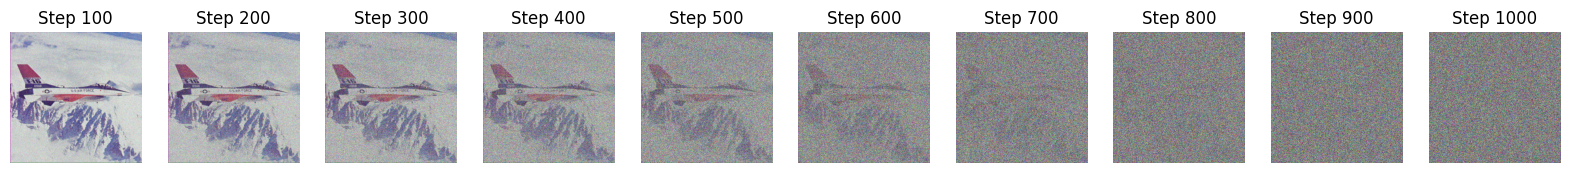

In [4]:
# define forward diffusion function for the DDPM stages
def forward_diffusion(x0, num_steps, beta_start, beta_end):
    betas = np.linspace(beta_start, beta_end, num_steps)
    alphas = 1 - betas
    alphas_cumprod = np.cumprod(alphas)
    
    x_t = []
    x_t.append(x0)
    for t in range(1, num_steps + 1):
        noise = np.random.randint(x0.min(), x0.max(), size=x0.shape)
        alpha_t = alphas_cumprod[t-1]
        x_t_prev = x_t[-1]
        x_t_current = np.sqrt(alpha_t) * x0 + np.sqrt(1 - alpha_t) * noise
        x_t.append(x_t_current)
    
    # Starting from step 100, I set it as Stage 1. Step 110 -> Stage 2, and so on
    output = np.array(x_t)[100::10]
    for i in range(len(output)):
        img_array = output[i]
        img_array = (img_array - img_array.min()) / (img_array.max() - img_array.min())  # Normalize to [0, 1]
        output[i] = img_array
    
    return output, alphas_cumprod

def plot_images(x_t, indices):
    num_images = len(indices)
    fig, axes = plt.subplots(1, num_images, figsize=(20, 12))
    for ax, idx in zip(axes, indices):
        ax.imshow(x_t[idx])
        ax.set_title(f'Step {idx*10+100}')
        ax.axis('off')
    plt.show()

# parameters for forward diffusion
x0 = img
num_steps = 1000
beta_start = 0.0001
beta_end = 0.02
x_t, alphas_cumprod = forward_diffusion(x0, num_steps, beta_start, beta_end)

# plot some stages to check the forward diffusion results
plot_images(x_t, indices=[i for i in range(0, 100, 10)])

In [6]:
# setup cnn class
class CNN(nn.Module):
    def __init__(self, n_layer, n_channel, kernel_size):
        super(CNN, self).__init__()
        pd = int(kernel_size/2)
        layers = [nn.Conv2d(3, n_channel, kernel_size, padding=pd), nn.PReLU(),]
        for _ in range(n_layer):
            layers.append(nn.Conv2d(n_channel, n_channel, kernel_size, padding=pd))
            layers.append(nn.BatchNorm2d(n_channel)) # normalize
            layers.append(nn.PReLU())
        layers.append(nn.Conv2d(n_channel, 3, kernel_size, padding=pd))
        
        self.deep_net = nn.Sequential(*layers)
        
    def forward(self, x):
        x = x.permute(2, 0, 1)
        return torch.squeeze(self.deep_net(x.unsqueeze(0)))
    
cnn = CNN(64, 64, 3).to(device)

Text(0.5, 1.0, 'input image 512 x 512')

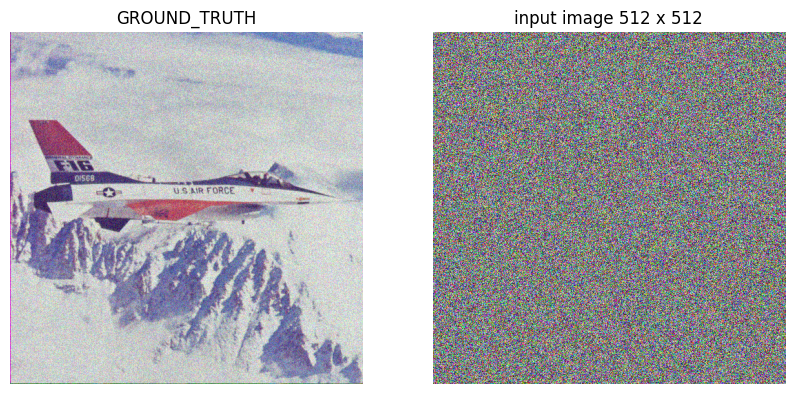

In [7]:
# input image is pure noise
input_image = torch.rand(nxd, nxd, 3).to(device)  

def torch_to_numpy(torch_array):
    return np.squeeze(torch_array.detach().cpu().numpy())
def numpy_to_torch(numpy_array):
    return torch.from_numpy(numpy_array).float()

fig2, axis2 = plt.subplots(1, 2, figsize=(10,6))
# I set step 100 image as my ground truth
axis2[0].imshow(x_t[1])
axis2[0].set_title('GROUND_TRUTH')
axis2[0].set_axis_off()
axis2[1].set_axis_off()
axis2[1].imshow(torch_to_numpy(input_image))
axis2[1].set_title('input image %d x %d' %(nxd, nxd))

In [8]:
# initialize training valiables
optimiser = torch.optim.Adam(cnn.parameters(), lr=1e-4)
train_loss = []
psnr_list = []
psnr_list_at_each_stage = []
output_images = []
output_psnr = [] # records max psnr for each stage

print("Total stages:", len(x_t))

Total stages: 91


In [9]:
mse_fn = nn.MSELoss().to(device)

# training process starting from heavily corrupted images
for ind in range(len(x_t)-1, 1, -1):
    psnr_list = []
    cnt = 0
    for ep in tqdm(range(30)):
        optimiser.zero_grad()
        output_image = cnn(input_image)
        output_image = output_image.squeeze(0).permute(1, 2, 0)
        loss = mse_fn(numpy_to_torch(x_t[ind]).to(device), output_image)
    
        train_loss.append(loss.item())
        loss.backward() # find gradients
        optimiser.step() # does the update

        psnr = compare_psnr(torch_to_numpy(output_image), x_t[1], data_range=x_t[1].max())
        
        # early stop the stage when psnr value doesn't increase for 3 consecutive times
        if(ep > 1 and psnr.item() < psnr_list[-1]):
            cnt += 1
        psnr_list.append(psnr.item())
        if(cnt > 3):
            break
    
    print(ind)
    print(loss.item())
    output_images.append(output_image)
    psnr_list_at_each_stage.append(psnr_list)
    output_psnr.append(max(psnr_list))

100%|██████████| 30/30 [00:32<00:00,  1.08s/it]


90
0.08868598192930222


 87%|████████▋ | 26/30 [00:29<00:04,  1.12s/it]


89
0.0723985880613327


 17%|█▋        | 5/30 [00:06<00:32,  1.31s/it]


88
0.08364298194646835


 73%|███████▎  | 22/30 [00:25<00:09,  1.16s/it]


87
0.07341943681240082


 17%|█▋        | 5/30 [00:06<00:34,  1.36s/it]


86
0.08216345310211182


 67%|██████▋   | 20/30 [00:23<00:11,  1.20s/it]


85
0.07393728941679001


 17%|█▋        | 5/30 [00:06<00:33,  1.35s/it]


84
0.08140488713979721


 63%|██████▎   | 19/30 [00:22<00:12,  1.17s/it]


83
0.07437771558761597


 17%|█▋        | 5/30 [00:06<00:33,  1.34s/it]


82
0.08081106841564178


 63%|██████▎   | 19/30 [00:22<00:12,  1.18s/it]


81
0.07416905462741852


 17%|█▋        | 5/30 [00:06<00:33,  1.36s/it]


80
0.0799965113401413


 67%|██████▋   | 20/30 [00:23<00:11,  1.19s/it]


79
0.07389461994171143


 17%|█▋        | 5/30 [00:06<00:33,  1.35s/it]


78
0.0801369696855545


 63%|██████▎   | 19/30 [00:22<00:12,  1.18s/it]


77
0.07347738742828369


 17%|█▋        | 5/30 [00:06<00:33,  1.35s/it]


76
0.07901499420404434


 60%|██████    | 18/30 [00:21<00:14,  1.19s/it]


75
0.07312945276498795


 17%|█▋        | 5/30 [00:06<00:33,  1.35s/it]


74
0.07884448766708374


 57%|█████▋    | 17/30 [00:20<00:15,  1.19s/it]


73
0.07304789870977402


 43%|████▎     | 13/30 [00:15<00:20,  1.21s/it]


72
0.07393375784158707


 47%|████▋     | 14/30 [00:16<00:19,  1.21s/it]


71
0.07313604652881622


 17%|█▋        | 5/30 [00:06<00:33,  1.35s/it]


70
0.07655976712703705


 60%|██████    | 18/30 [00:21<00:14,  1.19s/it]


69
0.07118602097034454


 27%|██▋       | 8/30 [00:10<00:27,  1.27s/it]


68
0.07434763014316559


 40%|████      | 12/30 [00:14<00:21,  1.22s/it]


67
0.07212834805250168


 40%|████      | 12/30 [00:14<00:21,  1.22s/it]


66
0.07138007134199142


 23%|██▎       | 7/30 [00:09<00:29,  1.29s/it]


65
0.07281539589166641


 40%|████      | 12/30 [00:14<00:21,  1.22s/it]


64
0.07058335840702057


 43%|████▎     | 13/30 [00:15<00:20,  1.21s/it]


63
0.06959107518196106


 43%|████▎     | 13/30 [00:15<00:20,  1.21s/it]


62
0.06926288455724716


 20%|██        | 6/30 [00:07<00:31,  1.31s/it]


61
0.07049056887626648


 27%|██▋       | 8/30 [00:10<00:27,  1.27s/it]


60
0.06969588994979858


 27%|██▋       | 8/30 [00:10<00:27,  1.27s/it]


59
0.06834056973457336


 20%|██        | 6/30 [00:07<00:31,  1.31s/it]


58
0.0682685375213623


 33%|███▎      | 10/30 [00:12<00:24,  1.24s/it]


57
0.06623911112546921


 33%|███▎      | 10/30 [00:12<00:24,  1.24s/it]


56
0.06555651128292084


 27%|██▋       | 8/30 [00:10<00:27,  1.27s/it]


55
0.06526421755552292


 33%|███▎      | 10/30 [00:12<00:24,  1.24s/it]


54
0.06376441568136215


 37%|███▋      | 11/30 [00:13<00:23,  1.23s/it]


53
0.06245872378349304


 27%|██▋       | 8/30 [00:10<00:27,  1.27s/it]


52
0.06220660358667374


 47%|████▋     | 14/30 [00:16<00:19,  1.21s/it]


51
0.05997435748577118


 27%|██▋       | 8/30 [00:10<00:27,  1.26s/it]


50
0.06041417643427849


 43%|████▎     | 13/30 [00:15<00:20,  1.21s/it]


49
0.05809500440955162


 43%|████▎     | 13/30 [00:15<00:20,  1.21s/it]


48
0.05717231333255768


 20%|██        | 6/30 [00:07<00:31,  1.31s/it]


47
0.05771492049098015


 43%|████▎     | 13/30 [00:15<00:20,  1.21s/it]


46
0.05494134873151779


 33%|███▎      | 10/30 [00:12<00:24,  1.24s/it]


45
0.05441679805517197


 33%|███▎      | 10/30 [00:12<00:24,  1.24s/it]


44
0.05322743579745293


 27%|██▋       | 8/30 [00:10<00:27,  1.26s/it]


43
0.05235850811004639


 40%|████      | 12/30 [00:14<00:21,  1.22s/it]


42
0.05131717771291733


 27%|██▋       | 8/30 [00:10<00:27,  1.27s/it]


41
0.05029212683439255


 33%|███▎      | 10/30 [00:12<00:24,  1.24s/it]


40
0.04853282868862152


 33%|███▎      | 10/30 [00:12<00:24,  1.24s/it]


39
0.04736801236867905


 40%|████      | 12/30 [00:14<00:21,  1.22s/it]


38
0.04583447799086571


 30%|███       | 9/30 [00:11<00:26,  1.25s/it]


37
0.045362334698438644


 30%|███       | 9/30 [00:11<00:26,  1.25s/it]


36
0.04427073523402214


 30%|███       | 9/30 [00:11<00:26,  1.25s/it]


35
0.04300706833600998


 30%|███       | 9/30 [00:11<00:26,  1.25s/it]


34
0.041469745337963104


 27%|██▋       | 8/30 [00:10<00:27,  1.26s/it]


33
0.04065930098295212


 30%|███       | 9/30 [00:11<00:26,  1.25s/it]


32
0.03947719931602478


 27%|██▋       | 8/30 [00:10<00:27,  1.26s/it]


31
0.03846924006938934


 23%|██▎       | 7/30 [00:08<00:29,  1.28s/it]


30
0.03711013123393059


 27%|██▋       | 8/30 [00:10<00:27,  1.27s/it]


29
0.03602893278002739


 20%|██        | 6/30 [00:07<00:31,  1.31s/it]


28
0.034955404698848724


 30%|███       | 9/30 [00:11<00:26,  1.25s/it]


27
0.03354714810848236


 37%|███▋      | 11/30 [00:13<00:23,  1.23s/it]


26
0.031988151371479034


 27%|██▋       | 8/30 [00:10<00:27,  1.26s/it]


25
0.031373441219329834


 30%|███       | 9/30 [00:11<00:26,  1.25s/it]


24
0.02950078248977661


 23%|██▎       | 7/30 [00:08<00:29,  1.28s/it]


23
0.028808360919356346


 33%|███▎      | 10/30 [00:12<00:24,  1.24s/it]


22
0.027299746870994568


 23%|██▎       | 7/30 [00:08<00:29,  1.29s/it]


21
0.02637084200978279


 30%|███       | 9/30 [00:11<00:26,  1.25s/it]


20
0.025423413142561913


 27%|██▋       | 8/30 [00:10<00:27,  1.26s/it]


19
0.02401295304298401


 33%|███▎      | 10/30 [00:12<00:24,  1.24s/it]


18
0.02304030954837799


 30%|███       | 9/30 [00:11<00:26,  1.25s/it]


17
0.021995415911078453


 33%|███▎      | 10/30 [00:12<00:24,  1.24s/it]


16
0.020765220746397972


 33%|███▎      | 10/30 [00:12<00:24,  1.24s/it]


15
0.019817732274532318


 30%|███       | 9/30 [00:11<00:26,  1.25s/it]


14
0.01868443749845028


 33%|███▎      | 10/30 [00:12<00:24,  1.24s/it]


13
0.017580997198820114


 33%|███▎      | 10/30 [00:12<00:24,  1.24s/it]


12
0.016662543639540672


 27%|██▋       | 8/30 [00:10<00:27,  1.26s/it]


11
0.015745531767606735


 27%|██▋       | 8/30 [00:10<00:27,  1.26s/it]


10
0.014508197084069252


 27%|██▋       | 8/30 [00:10<00:27,  1.26s/it]


9
0.01381470076739788


 23%|██▎       | 7/30 [00:08<00:29,  1.28s/it]


8
0.01285446435213089


 27%|██▋       | 8/30 [00:10<00:27,  1.26s/it]


7
0.011823493055999279


 27%|██▋       | 8/30 [00:10<00:27,  1.26s/it]


6
0.011138325557112694


 27%|██▋       | 8/30 [00:10<00:27,  1.26s/it]


5
0.010088242590427399


 30%|███       | 9/30 [00:11<00:26,  1.25s/it]


4
0.0090940585359931


 23%|██▎       | 7/30 [00:08<00:29,  1.28s/it]


3
0.008353663608431816


 30%|███       | 9/30 [00:11<00:26,  1.25s/it]

2
0.007298916578292847


In [10]:
# plot the result images from last 10 stages
fig1, axis1 = plt.subplots(1, 10, figsize=(20,12))
for i in range(1, 11):
    axis1[i-1].set_axis_off()
    axis1[i-1].imshow(torch_to_numpy(output_images[i*-1]))

Text(0.5, 1.0, 'Output Image')

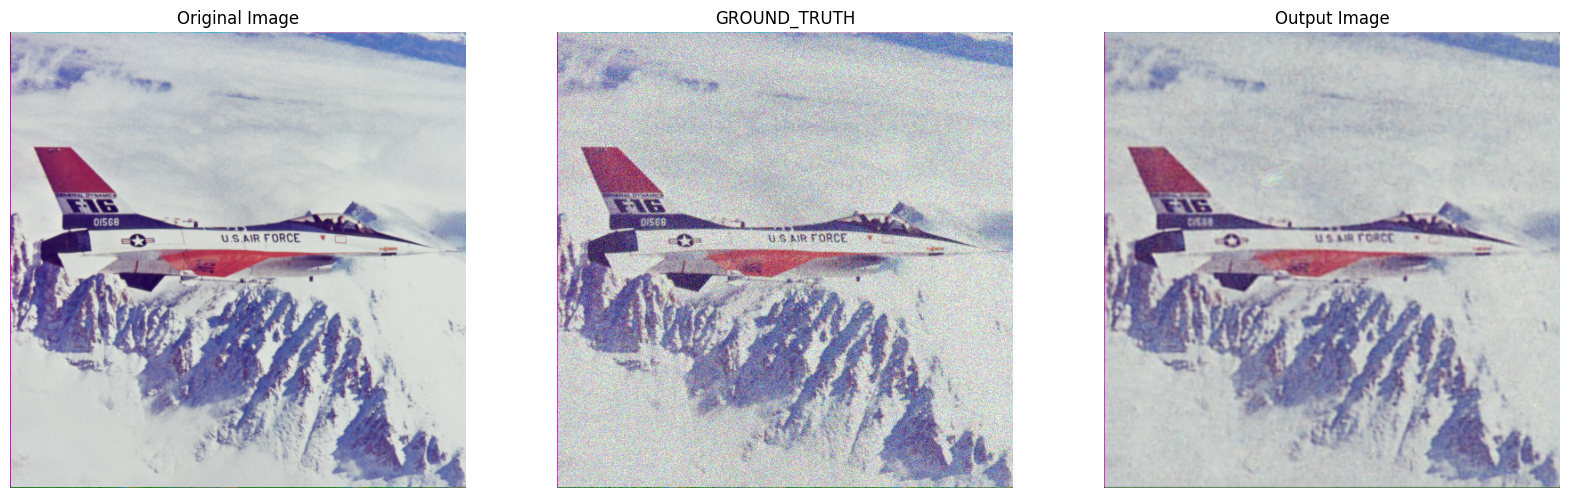

In [11]:
fig1, axis1 = plt.subplots(1, 3, figsize=(20,12))
axis1[0].imshow(img)
axis1[0].set_axis_off()
axis1[0].set_title('Original Image')
axis1[1].imshow(x_t[1])
axis1[1].set_axis_off()
axis1[1].set_title('GROUND_TRUTH')
axis1[2].imshow(torch_to_numpy(output_images[-1]))
axis1[2].set_axis_off()
axis1[2].set_title('Output Image')

Text(0, 0.5, 'MSE')

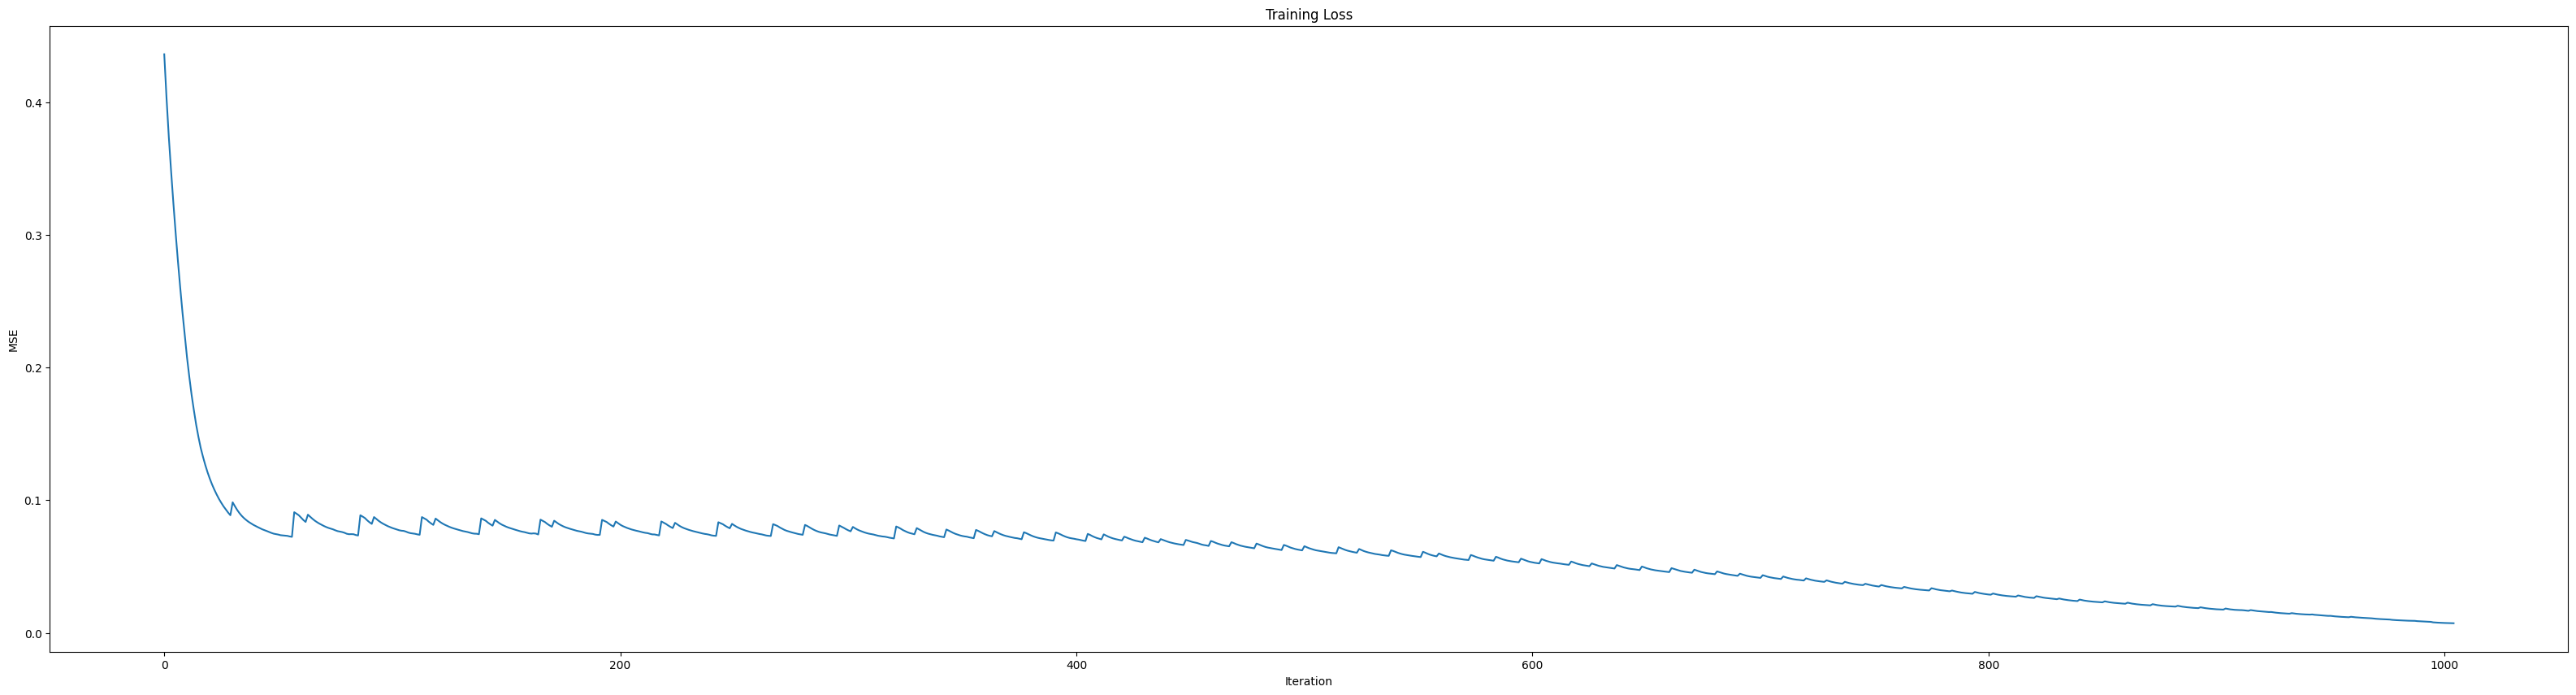

In [12]:
fig1, axis1 = plt.subplots(1, 1, figsize=(40, 10))
axis1.plot(train_loss)
axis1.set_title('Training Loss')
plt.xlabel("Iteration")
plt.ylabel("MSE")

Text(0, 0.5, 'PSNR')

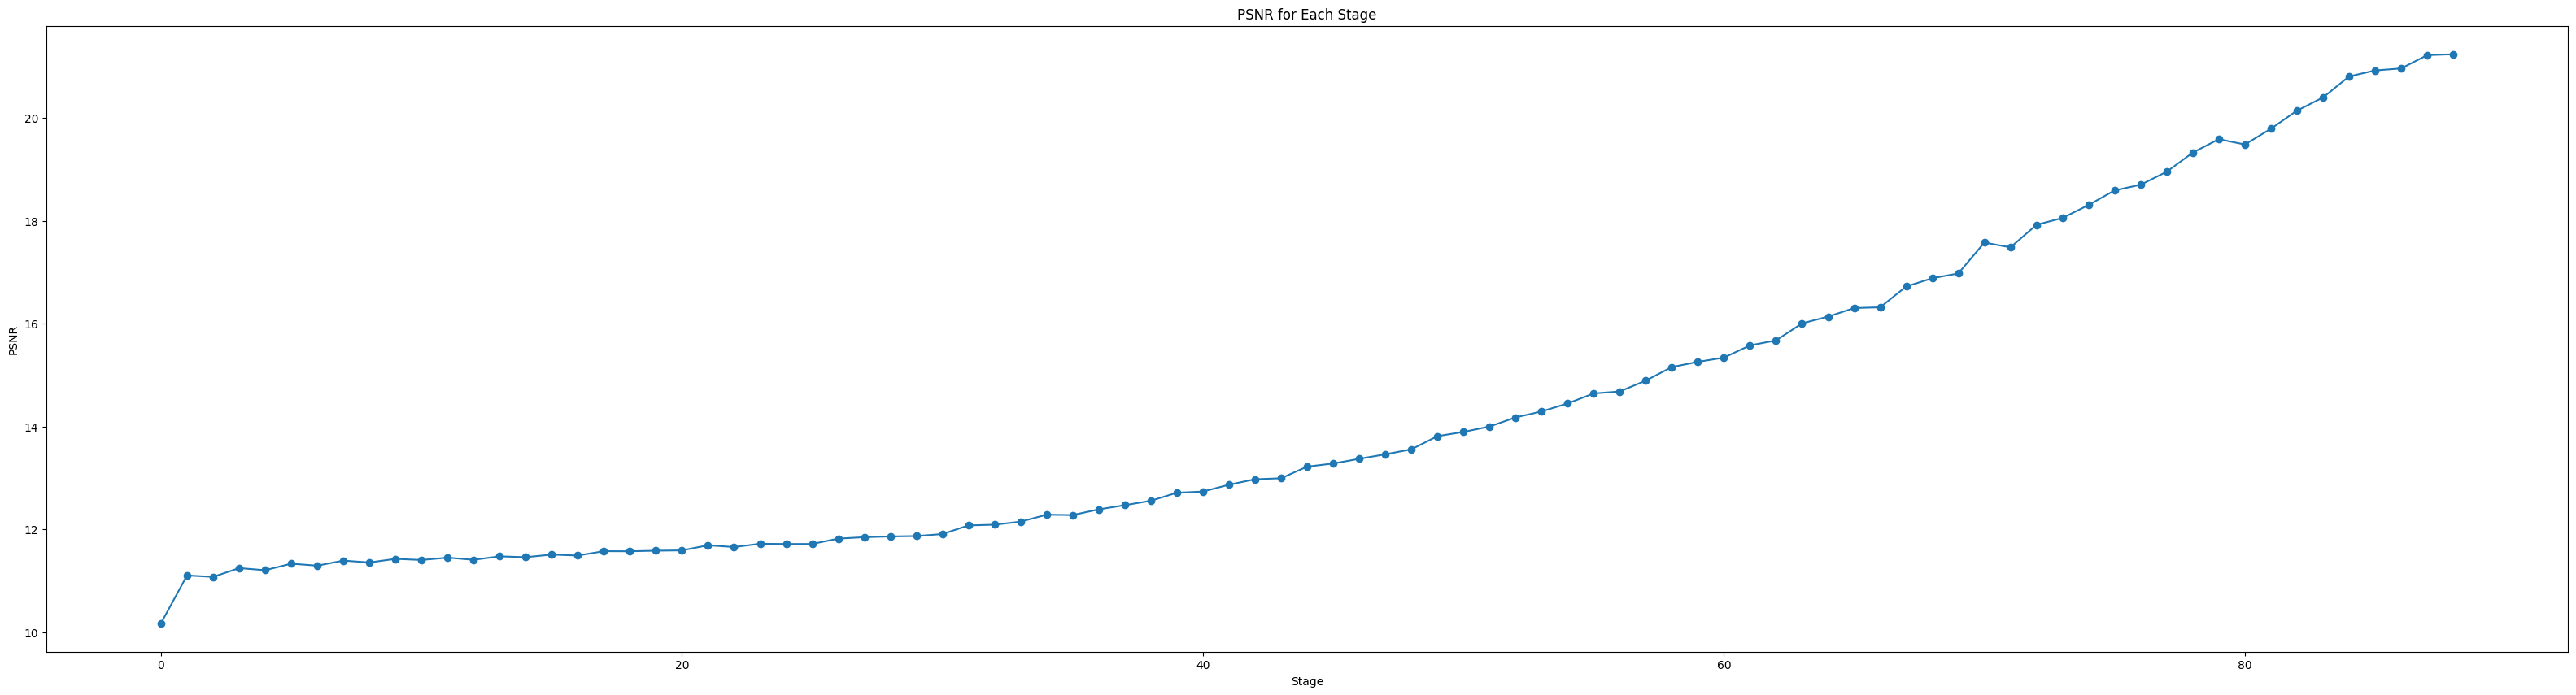

In [13]:
fig1, axis1 = plt.subplots(1, 1, figsize=(40, 10))
axis1.plot(output_psnr, marker = 'o')
axis1.set_title('PSNR for Each Stage')
plt.xlabel("Stage")
plt.ylabel("PSNR")

In [14]:
# Calculate PSNR for output image and original image
original_img = (img - img.min()) / (img.max() - img.min())
compare_psnr(torch_to_numpy(output_images[-1]), original_img, data_range=original_img.max())

20.06573887125522